In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
import time

In [2]:
class AP_NN(nn.Module):
    def __init__(self, K_no, L_no, H_no, T_no, device):
        super().__init__()
        
        self.K_no = K_no
        self.L_no = L_no
        self.H_no = H_no
        self.T_no = T_no
        self.device = device
        
        nn_list = []
        for l in range(self.L_no):
            if l == 0:
                nn_list.append(nn.Conv1d(in_channels=2, out_channels=H_no, kernel_size=K_no, padding=0))
                #nn_list.append(nn.Tanh())
                nn_list.append(nn.LeakyReLU())
            elif l == self.L_no - 1:
                nn_list.append(nn.Conv1d(in_channels=H_no, out_channels=1, kernel_size=1, padding=0))
            else:
                nn_list.append(nn.Conv1d(in_channels=H_no, out_channels=H_no, kernel_size=1, padding=0))
                #nn_list.append(nn.Tanh())
                nn_list.append(nn.LeakyReLU())
        
        self.nn = nn.Sequential(*nn_list)
        
        self.cos_basis_no = 30
        self.scale = 7.5
        self.shift = 1
        self.kern_basis = torch.zeros(self.cos_basis_no, T_no).to(device)
        for i in range(self.cos_basis_no):
            phi = 1.5707963267948966*i
            xmin = phi - 3.141592653589793
            xmax = phi + 3.141592653589793

            x_in = torch.arange(0, T_no, 1)
            raw_cos = self.scale  * torch.log(x_in + self.shift + 1e-7)

            basis = 0.5*torch.cos(raw_cos - phi) + 0.5
            basis[raw_cos < xmin] = 0.0
            basis[raw_cos > xmax] = 0.0
            self.kern_basis[i] = basis
        self.W_refract = nn.Parameter(torch.randn(self.cos_basis_no)*0.01)
        
    def train_forward(self, V, D, S):
        #V, D, S is shape (batch, 50000)
        
        input_pad = torch.zeros(V.shape[0], 2, V.shape[1] + self.K_no-1).to(self.device)
        input_pad[:,0,-V.shape[1]:] = input_pad[:,0,-V.shape[1]:] + V
        input_pad[:,1,-D.shape[1]:] = input_pad[:,1,-D.shape[1]:] + D
        
        S_pad = torch.zeros(S.shape[0], 1, S.shape[1] + self.T_no-1).to(self.device)
        S_pad[:, 0, -S.shape[1]:] = S_pad[:, 0, -S.shape[1]:] + S
        refract_kern = torch.flip(torch.matmul(self.kern_basis.T, self.W_refract), [0]) #(T_no)
        
        nn_out = self.nn(input_pad).squeeze(1) # (batch, 50000)
        S_conv = F.conv1d(S_pad, refract_kern.reshape(1,1,-1)).squeeze(1)
        
        P = torch.sigmoid(nn_out + S_conv)
        return P
    
    def test_forward(self, V, D):
        #V, D is shape (batch, 50000)
        
        input_pad = torch.zeros(V.shape[0], 2, V.shape[1] + self.K_no-1).to(self.device)
        input_pad[:,0,-V.shape[1]:] = input_pad[:,0,-V.shape[1]:] + V
        input_pad[:,1,-D.shape[1]:] = input_pad[:,1,-D.shape[1]:] + D
        
        refract_kern = torch.flip(torch.matmul(self.kern_basis.T, self.W_refract), [0]) #(T_no)
        
        nn_out = self.nn(input_pad).squeeze(1) # (batch, 50000)
        
        S_out_pad = torch.zeros(V.shape[0], V.shape[1] + self.T_no).to(self.device)
        P_out = torch.zeros(V.shape[0], V.shape[1]).to(self.device)
        
        for t in range(V.shape[1]):
            nn_t = nn_out[:,t].clone() #(batch)
            refract_t = torch.sum(S_out_pad[:,t:t+self.T_no].clone() * refract_kern.reshape(1,-1) , 1) #(batch)
            P_t = torch.sigmoid(nn_t + refract_t)
            S_out_pad[:,self.T_no+t] = S_out_pad[:,self.T_no+t] + torch.bernoulli(P_t)
            P_out[:,t] = P_out[:,t] + P_t
        
        S_out = S_out_pad[:,self.T_no:]
        return S_out, P_out



In [3]:
batch_size = 5
batch_length = 50000
K_no = 1
L_no = 2
H_no = 20
T_no = 501
device = torch.device("cuda")

epoch_no = 100
iter_no = epoch_no * 980 // batch_size

V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/comb_pred/V_comb_pred.npy").flatten()
D = np.zeros((V.shape[0]))
D[:-1] = np.diff(V)
#D = V.copy()
D = D.reshape(-1,batch_length)
V = V.reshape(-1,batch_length)
S = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/data/spk.npy").reshape(-1,batch_length)

V = torch.from_numpy(V)
D = torch.from_numpy(D)
S = torch.from_numpy(S)


In [4]:
V_train = V[:980].float()
V_test = V[980:].float().to(device)
D_train = D[:980].float()
D_test = D[980:].float().to(device)
S_train = S[:980].float()
S_test = S[980:].float() .to(device)

train_idx = np.empty((epoch_no, 980//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0,980,batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)


In [5]:
model = AP_NN(K_no, L_no, H_no, T_no, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

bce_criterion = nn.BCELoss(reduction="mean")

111


In [6]:
score_list = []

part_time_idx = torch.arange(12000,32000)

for i in tnrange(iter_no):
    s = time.time()
    model.train()
    optimizer.zero_grad()
    
    batch_idx_start = train_idx[i]
    batch_idx = torch.arange(batch_idx_start, batch_idx_start+5).long()
    batch_S = S_train[batch_idx].to(device)[:,part_time_idx]
    batch_V = V_train[batch_idx].to(device)[:,part_time_idx]
    batch_D = D_train[batch_idx].to(device)[:,part_time_idx]
    
    S_out, batch_P = model.test_forward(batch_V, batch_D)
    #batch_P = model.train_forward(batch_V, batch_D, batch_S)
    loss = bce_criterion(batch_P, batch_S)
    loss.backward()
    optimizer.step()
    
    step_time = time.time() - s
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_S_out, P_test = model.test_forward(V_test[:,part_time_idx], D_test[:,part_time_idx])
        test_loss = bce_criterion(P_test, S_test[:,part_time_idx]).item()
        
        score_list.append(test_loss)
        print(i, test_loss, step_time)

<ipython-input-6-0bb8ea78a585>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


  0%|          | 0/19600 [00:00<?, ?it/s]

0 0.5660656690597534 11.540967464447021
49 0.13995273411273956 11.697033882141113
99 0.10508427768945694 12.055019617080688
149 0.08772184699773788 11.92812204360962
199 0.07586076110601425 11.965021133422852
249 0.06757237017154694 12.187100172042847
299 0.0608924999833107 12.522115468978882
349 0.0554383285343647 12.119268894195557
399 0.05039117857813835 12.087712049484253
449 0.045996300876140594 12.026589155197144
499 0.04244004189968109 11.988090991973877
549 0.038563597947359085 12.131720066070557
599 0.03561520203948021 12.369555711746216
649 0.03207675367593765 11.980798721313477
699 0.02967669442296028 12.331401824951172
749 0.027076510712504387 11.893225908279419
799 0.024720443412661552 12.082522869110107
849 0.02253718674182892 11.914998769760132
899 0.02062053233385086 12.754130601882935
949 0.019056176766753197 12.614485502243042
999 0.01745535433292389 12.054714918136597
1049 0.01615961268544197 12.126040935516357
1099 0.014880486764013767 12.304299354553223
1149 0.0139

KeyboardInterrupt: 

In [8]:
# AP True
# 0.00019483866344671696 (V, D)
# 0.0006420775316655636 (V only)

# Na True
# 0.0012602820061147213 (V, D)
# 0.0018874892266467214 (V only)

# No Na True
# 0.0013189633609727025 (V, D)
# 0.0018882722361013293 (V only)

tensor(0.0352, device='cuda:0', grad_fn=<MaxBackward1>)


(0.0, 0.25)

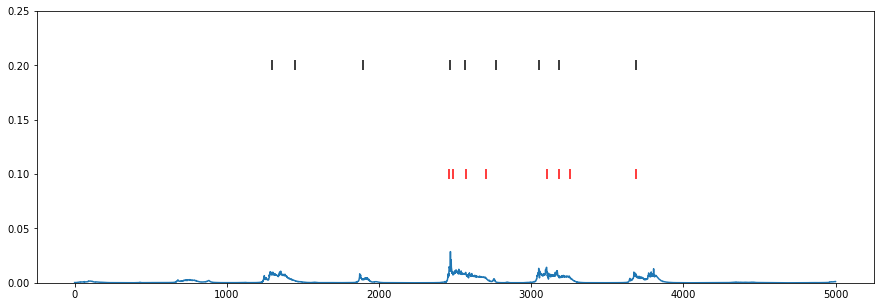

In [9]:
plt.figure(figsize = (15,5))
plt.plot(P_test[0][10000:15000].cpu().detach().numpy()[:])
plt.scatter(np.arange(5000), S_test[0][12000:32000][10000:15000].cpu().detach().numpy()-0.8, s=100, color="black", marker="|")
plt.scatter(np.arange(5000), test_S_out[0][10000:15000].cpu().detach().numpy()*0.9-0.8, s=100, color="red", marker="|")
print(torch.max(P_test))
plt.ylim(0,0.25)

In [10]:
print(model.W_refract)

Parameter containing:
tensor([-0.0736, -0.0659, -0.0514, -0.0819, -0.0686, -0.0580, -0.0571, -0.0713,
        -0.0655, -0.0548, -0.0797, -0.0690, -0.0780, -0.0737, -0.0669, -0.0584,
        -0.0791, -0.0658, -0.0851, -0.0567, -0.0777, -0.0607, -0.0820, -0.0544,
        -0.0594, -0.0449, -0.0556, -0.0695, -0.0523, -0.0618], device='cuda:0',
       requires_grad=True)
